
 TRANSACTION ANALYTICS DASHBOARD
--------------------------------------------------------------
1) Total & Average Transaction per Customer (with OUT overall avg)
2) Top 10 Customers (Last 6 Months): Count + Amount
3) Most Frequent Transaction Type
4) Monthly Transaction Trends (Amount)
5) High-Value Transactions (> ₹50,000)
--------------------------------------------------------------


 Enter your choice Between (1–5):  5


C:\Users\dines\AppData\Local\Temp\ipykernel_15092\2320653788.py:36: DeprecationWarning: Call to deprecated function stored_results. Reason: The property counterpart 'stored_results' will be added in a future release, and this method will be removed.
  for result in cursor.stored_results():
C:\Users\dines\AppData\Local\Temp\ipykernel_15092\2320653788.py:142: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=agg, x='transaction_type', y='amount', palette="magma")



High-Value Transactions (> ₹50,000)
-----------------------------------
 Showing first 5 and last 5 rows (data too large):

 transaction_id  customer_id     full_name      city transaction_type   amount    transaction_date
          20521         4357    Aarav Kale Ahmedabad          Deposit 92883.31 2024-05-24 13:52:12
          48743          968     Tara Bedi   Chennai          Deposit 72669.46 2025-07-26 00:13:42
          42950         2859     Zara Babu   Kolkata          Deposit 71289.11 2024-10-21 06:55:23
          44851          514   Charvi Apte     Delhi         Transfer 70494.89 2024-02-05 06:52:56
          33015         3643 Jayant Chahal     Delhi       Withdrawal 69762.43 2024-12-27 16:53:29

...

 transaction_id  customer_id           full_name      city transaction_type   amount    transaction_date
          15240         4169        Kimaya Kunda Ahmedabad          Deposit 51619.23 2025-04-21 03:30:19
          41347         2117         Yashvi Keer    Mumbai     Bi

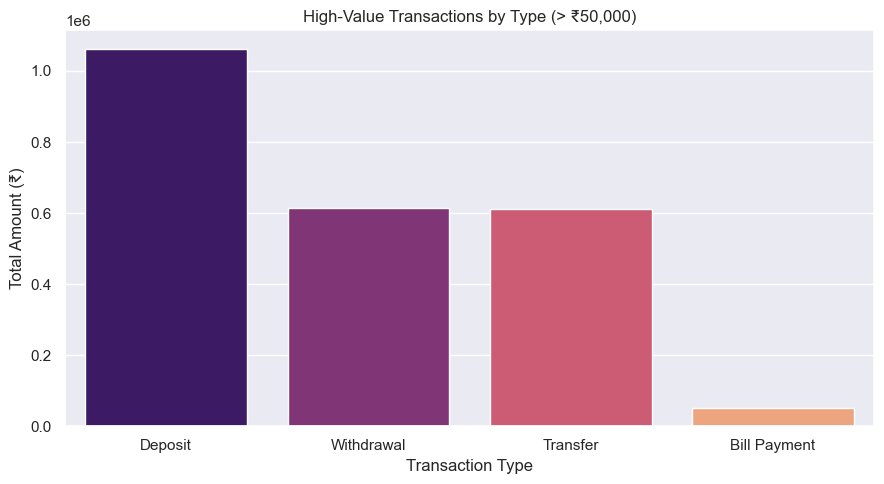

In [2]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mysql.connector import Error

# -----------------------------
# DB config
# -----------------------------
db_config = {
    "host": "localhost",
    "user": "root",
    "password": "14032002kD@",
    "database": "Banking"
}

# -----------------------------
# Stored proc runner
# -----------------------------
def run_proc(proc_name, params=None):
    """
    Execute stored procedure and return (df, updated_params).
    Pass OUT params inside a LIST so MySQL connector can write back.
    """
    conn = None
    try:
        conn = mysql.connector.connect(**db_config)
        cursor = conn.cursor()

        if params is not None:
            cursor.callproc(proc_name, params)  # list for OUT params
        else:
            cursor.callproc(proc_name)

        df = None
        for result in cursor.stored_results():
            rows = result.fetchall()
            cols = [c[0] for c in result.description]
            df = pd.DataFrame(rows, columns=cols)

        return df, params
    except Error as e:
        print(f" Error running {proc_name}: {e}")
        return None, params
    finally:
        try:
            cursor.close()
        except:
            pass
        if conn and conn.is_connected():
            conn.close()

# -----------------------------
# Table display helper (head+tail)
# -----------------------------
def show_table(df, title=None):
    if title:
        print(f"\n{title}\n" + "-" * len(title))
    if df is None or df.empty:
        print(" No rows.")
        return
    total = len(df)
    if total <= 10:
        print(df.to_string(index=False))
    else:
        print(" Showing first 5 and last 5 rows (data too large):\n")
        print(df.head(5).to_string(index=False))
        print("\n...\n")
        print(df.tail(5).to_string(index=False))
        print(f"\n Total rows: {total}")

# -----------------------------
# Visualizations (with different colors)
# -----------------------------
def viz_total_avg_per_customer(df, overall_avg, months):
    show_table(df, f"Total & Average Transaction Amount per Customer (last {months} month(s))")
    if df is None or df.empty:
        return

    plot_df = df.copy().sort_values('total_transaction_amount', ascending=False).head(15)
    plt.figure(figsize=(11,6))
    sns.barplot(data=plot_df, x="full_name", y="total_transaction_amount", palette="Set2")
    plt.title(f"Customer Total Transaction Amounts (last {months} month(s))")
    plt.xlabel("Customer"); plt.ylabel("Total Amount (₹)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

def viz_top10_last6months(df):
    show_table(df, "Top 10 Customers by Transaction Count (Last 6 Months)")
    if df is None or df.empty:
        return

    df_plot = df.sort_values('transaction_count', ascending=False)
    fig, ax1 = plt.subplots(figsize=(11,6))
    sns.barplot(data=df_plot, x='full_name', y='transaction_count', ax=ax1, palette="rocket")
    ax1.set_xlabel("Customer")
    ax1.set_ylabel("Transactions (count)")
    ax1.set_title("Top 10 Customers (Last 6 Months): Count (bars) + Total Amount (line)")
    plt.xticks(rotation=45, ha='right')

    ax2 = ax1.twinx()
    ax2.plot(range(len(df_plot)), df_plot['total_transaction_amount'], marker='o', color="blue", linewidth=2)
    ax2.set_ylabel("Total Amount (₹)")
    fig.tight_layout()
    plt.show()

def viz_most_frequent_type(df):
    show_table(df, "Most Frequent Transaction Type")
    if df is None or df.empty:
        return

    plt.figure(figsize=(6,4))
    sns.barplot(data=df, x='transaction_type', y='total_transactions', palette="Pastel1")
    plt.title("Most Frequent Transaction Type")
    plt.xlabel("Transaction Type"); plt.ylabel("Total Transactions")
    plt.tight_layout()
    plt.show()

def viz_monthly_trends(df):
    show_table(df, "Monthly Transaction Trends")
    if df is None or df.empty:
        return

    df_plot = df.sort_values('month')
    plt.figure(figsize=(11,6))
    sns.lineplot(data=df_plot, x='month', y='total_transaction_amount', marker='o', color="green")
    plt.title("Monthly Transaction Amount Trend")
    plt.xlabel("Month"); plt.ylabel("Total Amount (₹)")
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

def viz_high_value(df):
    show_table(df, "High-Value Transactions (> ₹50,000)")
    if df is None or df.empty:
        return

    agg = df.groupby('transaction_type', as_index=False)['amount'].sum().sort_values('amount', ascending=False)
    plt.figure(figsize=(9,5))
    sns.barplot(data=agg, x='transaction_type', y='amount', palette="magma")
    plt.title("High-Value Transactions by Type (> ₹50,000)")
    plt.xlabel("Transaction Type"); plt.ylabel("Total Amount (₹)")
    plt.tight_layout()
    plt.show()

# -----------------------------
# Interactive menu
# -----------------------------
def main():
    print("\n TRANSACTION ANALYTICS DASHBOARD")
    print("--------------------------------------------------------------")
    print("1) Total & Average Transaction per Customer (with OUT overall avg)")
    print("2) Top 10 Customers (Last 6 Months): Count + Amount")
    print("3) Most Frequent Transaction Type")
    print("4) Monthly Transaction Trends (Amount)")
    print("5) High-Value Transactions (> ₹50,000)")
    print("--------------------------------------------------------------")

    choice = input(" Enter your choice Between (1–5): ").strip()

    if choice == "1":
        months = int(input("Enter months interval (e.g., 1, 2, 3, 6): ").strip())
        params = [months, 0.0]
        df, updated = run_proc("total_avg_transaction_per_customer", params)
        overall_avg = updated[1] if updated else None
        viz_total_avg_per_customer(df, overall_avg, months)

    elif choice == "2":
        df, _ = run_proc("top_10_customers_last6months")
        viz_top10_last6months(df)

    elif choice == "3":
        df, _ = run_proc("most_frequent_transaction_type")
        viz_most_frequent_type(df)

    elif choice == "4":
        df, _ = run_proc("monthly_transaction_trends")
        viz_monthly_trends(df)

    elif choice == "5":
        df, _ = run_proc("high_value_transactions")
        viz_high_value(df)

    else:
        print(" Invalid choice. Please enter 1–5 only.")

if __name__ == "__main__":
    sns.set_theme()
    main()
